In [6]:
import sys
import os
# Add the project root to sys.path
sys.path.append(os.path.abspath('..'))

from Functions.gradientdescent_lib import *
from Functions.crossvalidation_lib import *
from Functions.PLOT import plot
from Functions.bootstrap import *

In [7]:
#generate standard dataset

np.random.seed(1)
x_train, x_test, y_train, y_test = generateData(100, noise = 0.1)
x_train = x_train.flatten(); x_test = x_test.flatten()

Comparison of samplesize 20 with samplesize 80 (whole dataset)

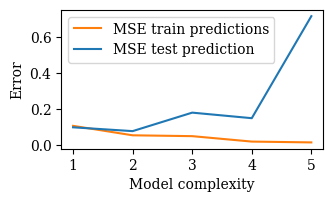

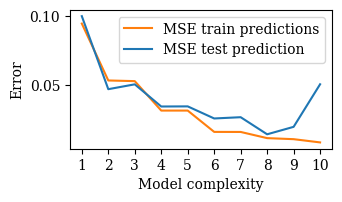

In [8]:
np.random.seed(1)
samplesizes = [20, 80]
n_degrees = [5, 10]

MSEs_train = []
MSEs_test = []

noIntercept = False

for i in range(2):
    samplesize = samplesizes[i]
    poly_degrees = list(range(1, n_degrees[i]+1))

    #pick out dataset
    indices = np.random.randint(0, len(x_train), size = samplesize)
    x_sample = x_train[indices]
    y_sample = y_train[indices]

    MSEs_train = np.zeros(len(poly_degrees), dtype=float)
    MSEs_test = np.zeros(len(poly_degrees), dtype=float)
    
    for p in poly_degrees:
        X_sample = featureMat(x_sample, p, noIntercept=noIntercept)
        X_test = featureMat(x_test, p, noIntercept=noIntercept)

        theta = theta_analytic_OLS(X_sample, y_sample)
        y_sample_pred = X_sample @ theta
        y_test_pred = X_test @ theta

        MSE_train = MSE(y_sample, y_sample_pred)
        MSE_test = MSE(y_test, y_test_pred)

        MSEs_train[p-1] = MSE_train
        MSEs_test[p-1] = MSE_test
    

    plot(
        nGraphs = 2,
        x_axis_array = poly_degrees,
        y_features = [MSEs_train, MSEs_test],
        y_feature_label = ['MSE train predictions', 'MSE test prediction'],
        foldername = 'figures',
        figurename = f'polynomial_fit_with{samplesize}',
        x_label = 'Model complexity',
        y_label = 'Error',
        title = '',
        x_integer_entries = True,
        y_integer_entries = False,
        save = True,
        scatter = None,
        multiX = False
    )

Bias-variance decomposition of models trained on the whole train data

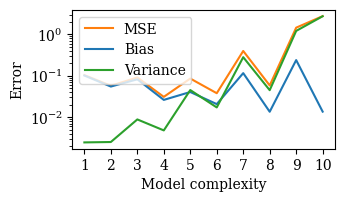

In [9]:
np.random.seed(1)
n_bootstraps = 500
n_degrees = 10
poly_degrees = list(range(1, n_degrees + 1))

MSEs = np.zeros(len(poly_degrees))
variances = np.zeros(len(poly_degrees))
biases = np.zeros(len(poly_degrees))

for i, p in enumerate(poly_degrees):
    X_train = featureMat(x_train, p, noIntercept=noIntercept)
    X_test = featureMat(x_test, p, noIntercept=noIntercept)

    mse, bias, variance = bootstrap(n_bootstraps, X_train, y_train, X_test, y_test, evaluate_OLS_analytic)
    
    MSEs[i] = mse
    biases[i] = bias
    variances[i] = variance

plot(
    nGraphs = 3,
    x_axis_array = poly_degrees,
    y_features = [MSEs, biases, variances],
    y_feature_label = ['MSE', 'Bias', 'Variance'],
    foldername = 'figures',
    figurename = f'bias-variance_model_complexity',
    x_label = 'Model complexity',
    y_label = 'Error',
    title = '',
    x_integer_entries = True,
    y_integer_entries = False,
    save = True,
    scatter = None,
    multiX = False,
    y_logplot = True
    )

Bias-variance decomposition of degree 6 polynomials trained using gradient descent with RMSprop and different gradients

In [10]:
np.random.seed(1)
x_train, x_test, y_train, y_test = generateData(100, noise = 0.1)
x_train = x_train.flatten(); x_test = x_test.flatten()

learningRate = 0.05
decay = 0.99
n_features = 6
noIntercept = False
n_bootstraps = 500

optimizer = Optimizers.RMSprop(learningRate, decay, n_features+int(not noIntercept))

gradient_OLS = Gradients.OLS()
gradient_Ridge = Gradients.Ridge(0.01)
gradient_Lasso = Gradients.Lasso(0.01)

GRADIENTS = [gradient_OLS, gradient_Ridge, gradient_Lasso]

results = np.ndarray((3, 3))

for i, gradient in enumerate(GRADIENTS):
    model = GradientDescent(n_features, noIntercept=False)
    model.setOptimizer(optimizer)
    model.setGradient(gradient)
    
    mse, bias, variance = bootstrap(n_bootstraps, x_train, y_train, x_test, y_test, model.evaluation_function())

    results[i, 0] = mse
    results[i, 1] = variance
    results[i, 2] = bias
    

print(results)

# Save results to a Latex table
description = "Bias-variance trade of for RMSprop with different gradients and 6 features."
convertToTable(results, "BiasVarianceModel.tex", ["MSE", "Variance", "Bias"], description, name="biasVarianceModel")


[[0.02168152 0.00477973 0.01690178]
 [0.04926389 0.00283601 0.04642788]
 [0.04678529 0.00418639 0.0425989 ]]
